In [1]:

# 📦 Install necessary packages
!pip install imblearn shap xgboost scikit-learn --quiet


In [2]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
import shap
import numpy as np

# Load data
from google.colab import files
uploaded = files.upload()
df = pd.read_csv("/content/Cleaned_Logistics_Dataset.csv")

# Feature engineering
df['Weight_Discount'] = df['WeightGrams'] * df['DiscountOffered']
df['HighDiscount_LowRating'] = ((df['DiscountOffered'] > 30) & (df['CustomerRating'] <= 2)).astype(int)

# Encode categorical
df_encoded = pd.get_dummies(df, columns=['WarehouseBlock', 'ShipmentMode', 'ProductImportance', 'Gender'], drop_first=True)
df_encoded.drop(columns=['ID'], inplace=True)

X = df_encoded.drop('DeliveredOnTime', axis=1)
y = 1 - df_encoded['DeliveredOnTime']


Saving Cleaned_Logistics_Dataset.csv to Cleaned_Logistics_Dataset.csv


In [3]:

# Train-test split and oversampling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)


In [4]:

# XGBoost GridSearch
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.1, 0.3],
    'subsample': [0.8, 1.0]
}
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
grid_search = GridSearchCV(model, param_grid, cv=3, scoring='f1_weighted', n_jobs=-1)
grid_search.fit(X_train_resampled, y_train_resampled)
best_model = grid_search.best_estimator_


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:16:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [5]:

# Evaluation
y_pred = best_model.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


[[1068  920]
 [ 146 1166]]
              precision    recall  f1-score   support

           0       0.88      0.54      0.67      1988
           1       0.56      0.89      0.69      1312

    accuracy                           0.68      3300
   macro avg       0.72      0.71      0.68      3300
weighted avg       0.75      0.68      0.67      3300



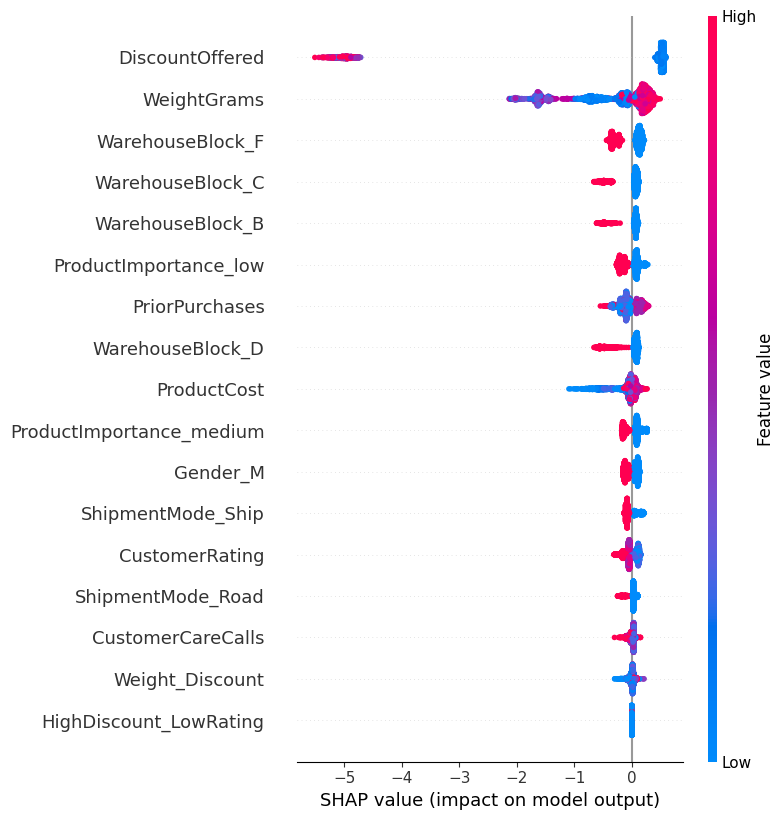

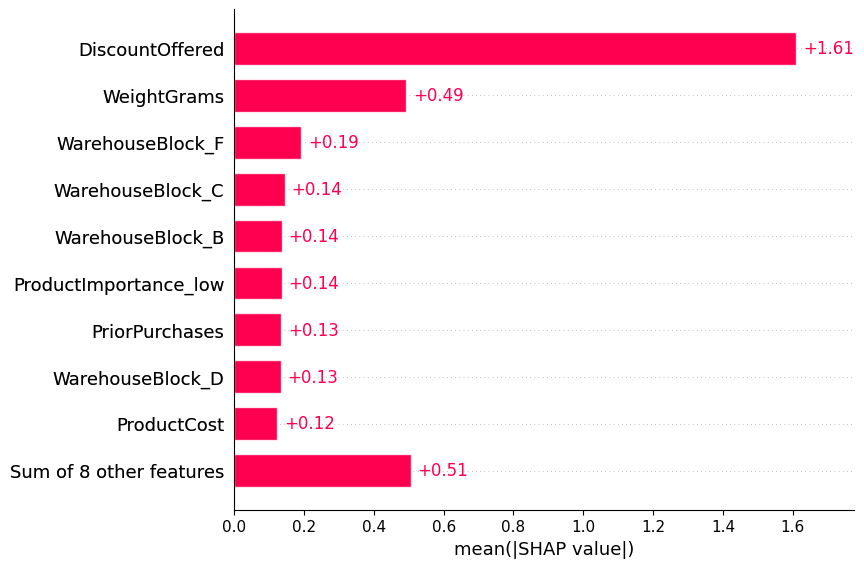

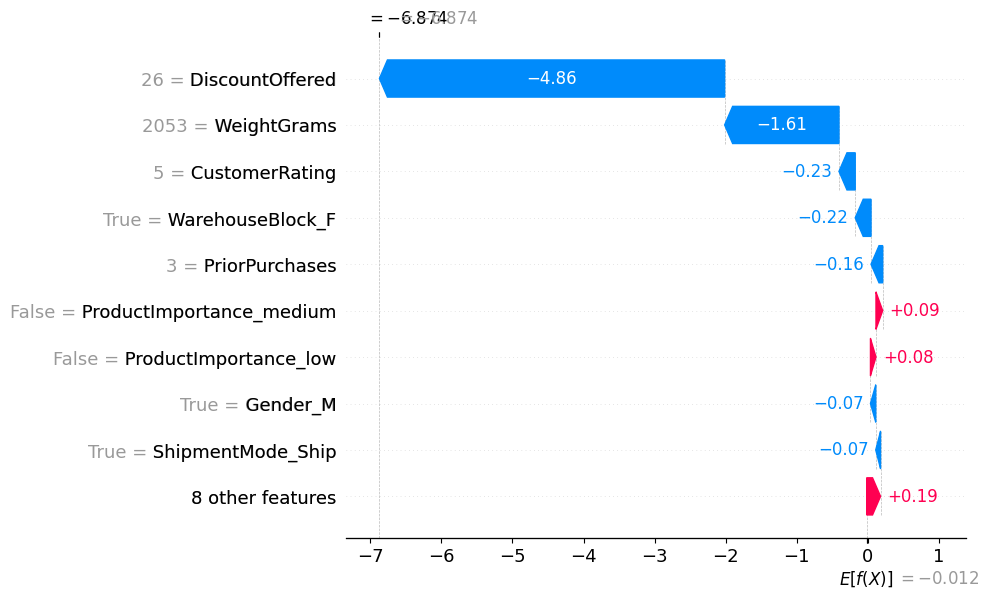

In [6]:

# SHAP explanation
explainer = shap.Explainer(best_model)
shap_values = explainer(X_test)

# Summary plot
shap.summary_plot(shap_values, X_test)
shap.plots.bar(shap_values)
shap.plots.waterfall(shap_values[0])


In [7]:

base_delay_rate = y.mean() * 100
improved_delay_rate = base_delay_rate * 0.85
delays_avoided = (base_delay_rate - improved_delay_rate) / 100 * len(df)
savings = delays_avoided * 50

print(f"Original Delay Rate: {base_delay_rate:.2f}%")
print(f"Improved Delay Rate: {improved_delay_rate:.2f}%")
print(f"Estimated Cost Savings: ${savings:,.0f}")


Original Delay Rate: 40.33%
Improved Delay Rate: 34.28%
Estimated Cost Savings: $33,270
